### 1. Data Preparation
Data Set
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn



batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


### Inspecting Dataset

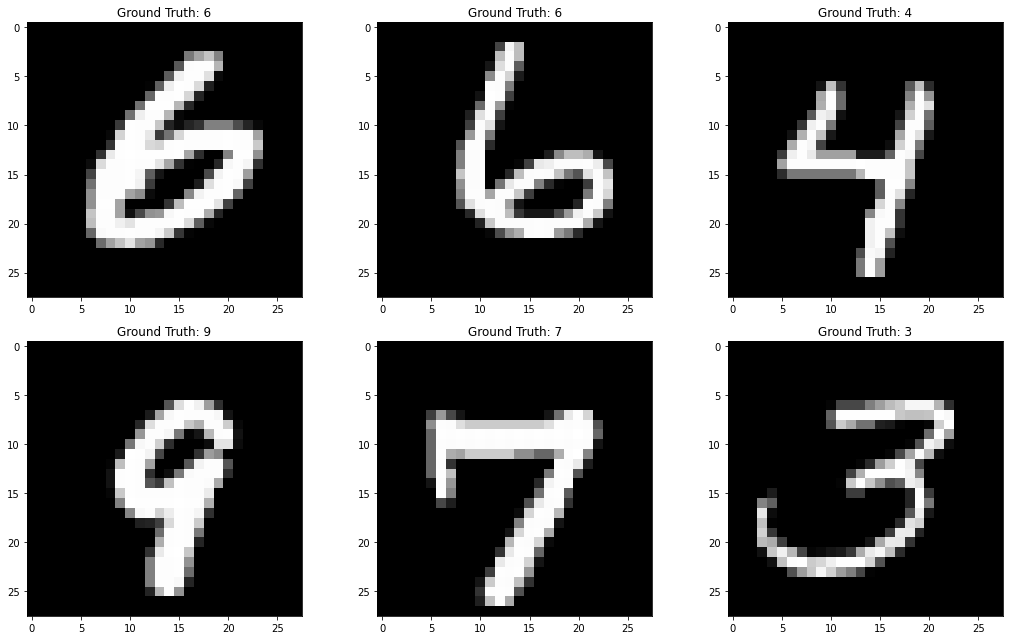

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

### 2. Model Architecture

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features = 784, out_features = 10, bias = True)
        
    def forward(self, x):
        x = self.linear(x)
        return x
    
class MLPModel(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_dim, hid_dim)
        self.linear2 = nn.Linear(hid_dim, out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
        

### 3. Cost Function Define (Loss Function Define)

In [4]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [5]:
# print(torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time
# ====== Construct Model ====== #
model = MLPModel(784,10, 200)
print(torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.Adam(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    ts = time.time()
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
        
        te = time.time()
        print(te-ts)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.1f}'.format(i, train_loss, val_loss, acc*100, te-ts))

True
Number of 159010 parameters
7.303475856781006
Epoch: 0, Train Loss: 0.22646209062136652, Val Loss: 0.1355071499637222, Test Acc: 95.98%, 7.3
6.952563047409058
Epoch: 1, Train Loss: 0.11432393451156976, Val Loss: 0.12080592973028086, Test Acc: 96.41999999999999%, 7.0
6.972564458847046
Epoch: 2, Train Loss: 0.09127916509042615, Val Loss: 0.1461470632024015, Test Acc: 96.77%, 7.0
6.994325876235962
Epoch: 3, Train Loss: 0.07837532981491797, Val Loss: 0.14638287046499834, Test Acc: 96.55%, 7.0
6.953030109405518
Epoch: 4, Train Loss: 0.07237208748469724, Val Loss: 0.11635372313358408, Test Acc: 96.91%, 7.0
6.962310552597046
Epoch: 5, Train Loss: 0.06225927442382507, Val Loss: 0.1445001696768866, Test Acc: 96.83%, 7.0
6.971791744232178
Epoch: 6, Train Loss: 0.0628291773804835, Val Loss: 0.1344561536311573, Test Acc: 96.83%, 7.0
6.978566408157349
Epoch: 7, Train Loss: 0.05742776732298705, Val Loss: 0.15696141366807073, Test Acc: 97.19%, 7.0
6.97350287437439
Epoch: 8, Train Loss: 0.0526734

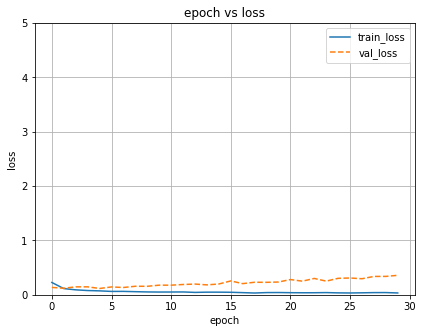

In [8]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.show()